In [311]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [312]:
class USBType(Enum):
    USB_A = "USB-A"
    USB_C = "USB-C"
    MICRO_USB = "Micro-USB"
    MINI_USB = "Mini-USB"
    USB_B = "USB-B"
    UNKNOWN = "Unknown"

In [313]:
images = [
    'test1.jpg',
    'test2.png',
    'test3.png',
    'test4.jpg',]
image_path = "/content/typea/1.PNG"
image = cv.imread(image_path)

In [314]:
# Parameters for feature extraction and classification
debug_mode = True  # Set to True to display intermediate steps

In [315]:
def display_steps(stage_name, images):

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(stage_name)

    for i, (title, img) in enumerate(images):
        if len(images) == 1:
            ax = axes
        else:
            ax = axes[i]

        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:  # Color
            ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [316]:
def preprocess_image(img):
    # Make a copy of the original image
    original_img = img.copy()

    # Convert to grayscale
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    gaussian_img = cv.GaussianBlur(gray_img, (7, 7), 0)

    # Apply Canny edge detection
    canny_img = cv.Canny(gaussian_img, 125, 175)

    # Find contours
    contours, _ = cv.findContours(canny_img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    # Filter by area (keep largest contour = USB)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv.contourArea)

        # Create a mask for the USB
        mask = np.zeros(gray_img.shape[:2], dtype='uint8')
        cv.drawContours(mask, [largest_contour], -1, 255, thickness=cv.FILLED)

        # Get bounding rectangle for the USB region
        x, y, w, h = cv.boundingRect(largest_contour)

        # Extract the USB region from the original grayscale image
        usb_region = gray_img[y:y+h, x:x+w].copy()

        # Extract the USB region from the Gaussian blurred image
        usb_region_gaussian = gaussian_img[y:y+h, x:x+w].copy()

        # Extract the USB region from Canny edges
        usb_region_canny = canny_img[y:y+h, x:x+w].copy()

        # Find contours in the extracted USB region
        usb_region_mask = mask[y:y+h, x:x+w].copy()
        region_contours, _ = cv.findContours(usb_region_mask, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

        if debug_mode:
            display_steps("Preprocessing", [
                ("Original", gray_img),
                ("Grayscale", gaussian_img),
                ("Canny", canny_img),
                ("USB Mask", mask),
                ("Extracted USB Region", usb_region)
            ])

        return original_img, gray_img, usb_region, region_contours, mask, largest_contour
    else:
        # If no contours found, return original data
        return original_img, gray_img, gray_img, [], None, None


In [317]:
def extract_features(usb_region, region_contours, full_mask=None, full_contour=None, original_gray=None):
    """
    Extract features from the USB region using contours and masks specific to that region.

    Args:
        usb_region: The extracted region containing just the USB
        region_contours: Contours found within the extracted USB region
        full_mask: Optional, the mask from the full image
        full_contour: Optional, the main USB contour from the full image
        original_gray: Optional, the full grayscale image
    """
    if len(region_contours) == 0:
        print("No contours found in USB region")
        return None

    # Create a mask for the USB region
    mask = np.zeros_like(usb_region)

    # Use the largest contour in the region (should be the USB outline)
    usb_contour = max(region_contours, key=cv.contourArea)
    cv.drawContours(mask, [usb_contour], -1, 255, thickness=cv.FILLED)

    # Calculate minimum area rectangle
    rect = cv.minAreaRect(usb_contour)
    box = cv.boxPoints(rect)
    box = np.int32(box)

    # Calculate aspect ratio
    width, height = rect[1]
    aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 0

    # Calculate area and perimeter
    area = cv.contourArea(usb_contour)
    perimeter = cv.arcLength(usb_contour, True)
    compactness = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    # Apply Canny edge detection to the USB region for pin detection
    usb_edges = cv.Canny(usb_region, 20, 80)  # Lower thresholds for better pin detection

    # Count internal contours that could be pins
    pin_candidates = []
    for cnt in region_contours:
        # Adjust area thresholds for pin detection
        if cv.contourArea(cnt) > 5 and cv.contourArea(cnt) < area * 0.2:
            pin_candidates.append(cnt)

    # Detect horizontal lines (USB-A pins are typically horizontal)
    horizontal_lines = 0
    if len(pin_candidates) > 0:
        for cnt in pin_candidates:
            x, y, w, h = cv.boundingRect(cnt)
            # Check if width significantly greater than height (horizontal orientation)
            if w > 1.5*h and w > 8:
                horizontal_lines += 1

    # Detect central line/slot feature for USB-C
    central_line_detected = False
    central_line_length = 0

    # Create a copy of the USB region for line detection
    line_detection_img = usb_region.copy()

    # Apply more aggressive edge detection for central line
    central_lines_edges = cv.Canny(line_detection_img, 50, 150)

    # Use HoughLinesP to detect lines
    lines = cv.HoughLinesP(central_lines_edges, 1, np.pi/180,
                           threshold=30, minLineLength=20, maxLineGap=10)

    # Check if any horizontal lines are detected in the center
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            # Check if line is mostly horizontal
            if abs(y2 - y1) < 0.2 * abs(x2 - x1):
                # Check if line is in the center region
                center_y = mask.shape[0] // 2
                if abs((y1 + y2) / 2 - center_y) < mask.shape[0] * 0.3:
                    central_line_detected = True
                    central_line_length = max(central_line_length, line_length)

    # Detect Harris corners
    corner_img = usb_region.copy()
    corner_img = np.float32(corner_img)
    harris_corners = cv.cornerHarris(corner_img, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv.dilate(harris_corners, None)

    # Count significant corners in the USB region only
    corner_threshold = 0.01 * harris_corners.max()
    masked_corners = cv.bitwise_and(harris_corners, harris_corners, mask=mask)
    corner_count = np.sum(masked_corners > corner_threshold)

    # Convexity defects analysis for pin detection
    hull = cv.convexHull(usb_contour, returnPoints=False)
    defects = None
    pin_count = 0

    try:
        if len(hull) > 3:  # Need at least 4 points for convexity defects
            defects = cv.convexityDefects(usb_contour, hull)
            if defects is not None:
                # Filter significant defects (potential pins)
                significant_defects = [defect for defect in defects if defect[0][3] > 1000]
                pin_count = len(significant_defects)
    except:
        pass

    # Analyze for rectangular shape (USB-A characteristic)
    # Calculate how rectangular the shape is by comparing area to bbox area
    x, y, w, h = cv.boundingRect(usb_contour)
    bbox_area = w * h
    rectangularity = area / bbox_area if bbox_area > 0 else 0

    # Symmetry analysis - improved for better USB-C detection
    # Vertical symmetry (important for USB-C)
    rows, cols = mask.shape

    # Get the vertical central axis
    center_col = cols // 2

    # Compare left and right halves
    left_half = mask[:, :center_col]
    right_half = mask[:, center_col:]
    right_half_flipped = cv.flip(right_half, 1)  # Flip horizontally

    # Crop to same size if needed
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    left_half_cropped = left_half[:, -min_width:]
    right_half_flipped_cropped = right_half_flipped[:, :min_width]

    # Calculate symmetry score (lower is more symmetric)
    if left_half_cropped.size > 0 and right_half_flipped_cropped.size > 0:
        diff = cv.bitwise_xor(left_half_cropped, right_half_flipped_cropped)
        # Normalize to 0-1:
        symmetry_score = np.sum(diff) / (255.0 * min_width * rows) if (min_width * rows) > 0 else 1.0
    else:
        symmetry_score = 1.0

    # Calculate roundedness at the ends (important for USB-C)
    # Use the contour to find the end curvature
    end_roundedness = 0.0
    try:
        # Fit ellipse to get roundedness information
        ellipse = cv.fitEllipse(usb_contour)
        major_axis, minor_axis = ellipse[1]
        # Roundedness is the ratio of minor to major (closer to 1 means more circular)
        if major_axis > 0:
            end_roundedness = min(minor_axis / major_axis, 1.0)
    except:
        pass

    # Create a feature dictionary
    features = {
        'contour': usb_contour,
        'box': box,
        'aspect_ratio': aspect_ratio,
        'area': area,
        'perimeter': perimeter,
        'compactness': compactness,
        'corner_count': corner_count,
        'pin_count': pin_count,
        'horizontal_lines': horizontal_lines,
        'symmetry_score': symmetry_score,
        'rectangularity': rectangularity,
        'mask': mask,
        'usb_region': usb_region,
        'usb_edges': usb_edges,
        'central_line_detected': central_line_detected,
        'central_line_length': central_line_length,
        'end_roundedness': end_roundedness
    }

    # Print feature values for debugging
    print(f"Extracted Features:")
    print(f"  - Aspect Ratio: {aspect_ratio:.2f}")
    print(f"  - Area: {area}")
    print(f"  - Perimeter: {perimeter:.2f}")
    print(f"  - Compactness: {compactness:.2f}")
    print(f"  - Corner Count: {corner_count}")
    print(f"  - Pin Count: {pin_count}")
    print(f"  - Horizontal Lines: {horizontal_lines}")
    print(f"  - Rectangularity: {rectangularity:.2f}")
    print(f"  - Symmetry Score: {symmetry_score:.8f}")
    print(f"  - Central Line Detected: {central_line_detected}")
    print(f"  - Central Line Length: {central_line_length:.2f}")
    print(f"  - End Roundedness: {end_roundedness:.2f}")

    if debug_mode:
        # Visualize features (use the extracted USB region for visualization)
        feature_vis = cv.cvtColor(usb_region, cv.COLOR_GRAY2BGR)
        cv.drawContours(feature_vis, [usb_contour], -1, (0, 255, 0), 2)
        cv.drawContours(feature_vis, [box], -1, (0, 0, 255), 2)

        # Visualize internal structures
        internal_vis = cv.cvtColor(usb_region, cv.COLOR_GRAY2BGR)
        cv.drawContours(internal_vis, pin_candidates, -1, (0, 0, 255), 1)

        # Visualize corners
        corner_vis = cv.cvtColor(usb_region, cv.COLOR_GRAY2BGR)
        corner_vis[harris_corners > corner_threshold] = [0, 0, 255]

        # Visualize central line if detected
        central_line_vis = cv.cvtColor(usb_region, cv.COLOR_GRAY2BGR)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv.line(central_line_vis, (x1, y1), (x2, y2), (0, 0, 255), 2)

        display_steps("Feature Extraction", [
            ("Contour & Bounding Box", feature_vis),
            ("Internal Features", internal_vis),
            ("USB Edges", usb_edges),
            ("Harris Corners", corner_vis),
            ("USB Mask", mask),
            ("Central Lines", central_line_vis),
            ("Extracted USB Region", usb_region)
        ])

    return features


In [318]:
def classify_usb_type(features):
    aspect_ratio = features['aspect_ratio']
    compactness = features['compactness']
    corner_count = features['corner_count']
    pin_count = features['pin_count']
    symmetry_score = features['symmetry_score']
    area = features['area']
    horizontal_lines = features.get('horizontal_lines', 0)
    rectangularity = features.get('rectangularity', 0)
    central_line_detected = features.get('central_line_detected', False)
    central_line_length = features.get('central_line_length', 0)
    end_roundedness = features.get('end_roundedness', 0)

    # Print feature values for debugging
    print(f"  Aspect Ratio: {aspect_ratio:.2f}")
    print(f"  Compactness: {compactness:.2f}")
    print(f"  Corner Count: {corner_count}")
    print(f"  Pin Count: {pin_count}")
    print(f"  Horizontal Lines: {horizontal_lines}")
    print(f"  Rectangularity: {rectangularity:.2f}")
    print(f"  Symmetry Score: {symmetry_score:.8f}")
    print(f"  Area: {area}")
    print(f"  Central Line Detected: {central_line_detected}")
    print(f"  Central Line Length: {central_line_length:.2f}")
    print(f"  End Roundedness: {end_roundedness:.2f}")

    # Create confidence scores for each USB type
    scores = {
        USBType.USB_A: 0.0,
        USBType.USB_B: 0.0,
        USBType.USB_C: 0.0,
        USBType.MICRO_USB: 0.0,
        USBType.MINI_USB: 0.0,
    }

    reasons = {
        USBType.USB_A: [],
        USBType.USB_B: [],
        USBType.USB_C: [],
        USBType.MICRO_USB: [],
        USBType.MINI_USB: []
    }

    # Calculate USB width robustly (ensure positive value)
    usb_width = max(abs(features['box'][1][0] - features['box'][0][0]), 1) if 'box' in features else central_line_length

    # USB-A scoring - Modified to better distinguish it from USB-C and Mini-USB
    if 1.7 <= aspect_ratio <= 3.5:
        # USB-A typically has aspect ratio between 1.7-3.5, but we need to distinguish it better
        # Give higher weight when aspect ratio is in USB-A's sweet spot (2.0-2.2)
        if 2.0 <= aspect_ratio <= 2.2:
            weight = 0.8  # Higher weight for ideal USB-A range
        else:
            weight = max(0.0, 0.6 - min(abs(aspect_ratio - 2.1) / 1.0, 0.6))  # Lower weight as we move away from ideal
        scores[USBType.USB_A] += weight * 0.25
        reasons[USBType.USB_A].append(f"Aspect ratio {aspect_ratio:.2f} fits USB-A range")

    # MOST CRITICAL FEATURE FOR USB-A: Horizontal lines (pins)
    if horizontal_lines >= 1:
        if horizontal_lines >= 3:
            # Strong indication of USB-A when there are many horizontal lines
            weight = min(horizontal_lines / 4.0, 1.0)
            scores[USBType.USB_A] += weight * 0.50  # Increased weight for horizontal lines
            reasons[USBType.USB_A].append(f"Detected {horizontal_lines} horizontal lines (pins)")

            # Explicitly penalize USB-C and Mini-USB when horizontal lines are detected
            scores[USBType.USB_C] -= weight * 0.35
            reasons[USBType.USB_C].append(f"USB-C typically doesn't have {horizontal_lines} horizontal lines")
            scores[USBType.MINI_USB] -= weight * 0.25
            reasons[USBType.MINI_USB].append(f"Mini-USB typically doesn't have {horizontal_lines} horizontal lines")
        else:
            # If only 1-2 horizontal lines, give less weight
            weight = horizontal_lines / 6.0
            scores[USBType.USB_A] += weight * 0.30
            reasons[USBType.USB_A].append(f"Detected {horizontal_lines} horizontal lines")

    # Additional USB-A characteristics
    if 4000 < area < 30000 and 1.7 <= aspect_ratio <= 3.0:
        size_weight = min((area - 4000) / 8000, 1.0)
        scores[USBType.USB_A] += size_weight * 0.20
        reasons[USBType.USB_A].append(f"Medium size (area: {area:.1f}) typical of USB-A")

    if rectangularity > 0.75:
        weight = min((rectangularity - 0.75) / 0.25, 1.0)
        scores[USBType.USB_A] += weight * 0.15
        reasons[USBType.USB_A].append(f"Rectangularity {rectangularity:.2f} matches USB-A profile")

    if compactness > 0.6:
        weight = min((compactness - 0.6) / 0.3, 1.0)
        scores[USBType.USB_A] += weight * 0.10
        reasons[USBType.USB_A].append(f"Compactness {compactness:.2f} fits USB-A")

    # USB-B Scoring - Improved for near-square connectors
    if 0.9 <= aspect_ratio <= 1.4:  # USB-B range is nearly square
        # Calculate how close to ideal 1.1 ratio
        ratio_score = 1.0 - min(abs(aspect_ratio - 1.1)/0.3, 1.0)
        scores[USBType.USB_B] += ratio_score * 0.50
        reasons[USBType.USB_B].append(f"Near-square aspect ratio ({aspect_ratio:.2f})")

        # Apply strong penalty to other types when aspect ratio is in USB-B range
        scores[USBType.USB_C] -= 0.35
        scores[USBType.USB_A] -= 0.25
        scores[USBType.MINI_USB] -= 0.30
        scores[USBType.MICRO_USB] -= 0.30

    # Add more USB-B criteria
    if rectangularity > 0.9 and 0.9 <= aspect_ratio <= 1.4:
        scores[USBType.USB_B] += 0.30
        reasons[USBType.USB_B].append(f"High rectangularity {rectangularity:.2f} with square aspect ratio")

    # Add a size criterion for USB-B
    if area > 10000 and 0.9 <= aspect_ratio <= 1.4:
        large_size_weight = min(1.0, area / 30000)
        scores[USBType.USB_B] += large_size_weight * 0.20
        reasons[USBType.USB_B].append(f"Large size (area: {area:.1f}) typical of USB-B")

    # Compactness is typically high for USB-B
    if compactness > 0.8 and 0.9 <= aspect_ratio <= 1.4:
        scores[USBType.USB_B] += 0.20
        reasons[USBType.USB_B].append(f"High compactness {compactness:.2f} typical of USB-B")

    # USB-C scoring - Made more specific to avoid confusion with other types
    if 2.8 <= aspect_ratio <= 3.8:  # Narrowed range for USB-C
        weight = 1.0 - min(abs(aspect_ratio - 3.0) / 0.8, 0.8)  # Ideal is around 3.0:1
        scores[USBType.USB_C] += weight * 0.25
        reasons[USBType.USB_C].append(f"Aspect ratio {aspect_ratio:.2f} fits USB-C range")
    elif aspect_ratio > 3.8 or aspect_ratio < 2.3:
        # Explicit penalty for aspect ratios far from USB-C range
        scores[USBType.USB_C] -= 0.20

    # Symmetry is critical for USB-C
    if symmetry_score < 0.18:  # Lower threshold for symmetry
        weight = 1.0 - min(symmetry_score / 0.18, 1.0)
        scores[USBType.USB_C] += weight * 0.35  # Increased weight for symmetry
        reasons[USBType.USB_C].append(f"High symmetry (score: {symmetry_score:.4f})")
    else:
        # Stronger penalty for poor symmetry
        scores[USBType.USB_C] -= 0.25
        reasons[USBType.USB_C].append(f"Low symmetry (score: {symmetry_score:.4f})")

    # Add central line as a USB-C feature, but be more precise
    if central_line_detected:
        line_relative_length = central_line_length / usb_width if usb_width > 0 else 0

        # Central line should be a substantial portion of the width for USB-C
        if line_relative_length > 0.7 and symmetry_score < 0.18:
            scores[USBType.USB_C] += 0.20
            reasons[USBType.USB_C].append(f"Strong central line ({line_relative_length:.2f} of width)")

            # Penalize Mini-USB more heavily for strong central line
            scores[USBType.MINI_USB] -= 0.20
            scores[USBType.MICRO_USB] -= 0.40  # Strong penalty for Micro-USB with central line
        elif line_relative_length > 0.5:
            scores[USBType.USB_C] += 0.10
            reasons[USBType.USB_C].append(f"Central line detected ({line_relative_length:.2f} of width)")
    else:
        # Absence of central line is a negative for USB-C
        scores[USBType.USB_C] -= 0.15
        reasons[USBType.USB_C].append("No central line detected")

    # Rounded ends are characteristic of USB-C
    if end_roundedness > 0.7:  # Increased threshold
        scores[USBType.USB_C] += 0.15
        reasons[USBType.USB_C].append(f"Rounded ends detected (score: {end_roundedness:.2f})")

    # Add horizontal lines as a stronger negative factor for USB-C
    if horizontal_lines > 2:
        penalty = min(horizontal_lines / 4.0, 1.0)
        scores[USBType.USB_C] -= penalty * 0.40  # Increased penalty
        reasons[USBType.USB_C].append(f"Too many horizontal lines ({horizontal_lines}) for USB-C")

    # Micro-USB scoring - More focused on its distinctive features
    # Micro-USB has a distinctive aspect ratio, typically around 2.8
    if 2.6 <= aspect_ratio <= 3.2:
        weight = 1.0 - min(abs(aspect_ratio - 2.8) / 0.4, 0.8)
        scores[USBType.MICRO_USB] += weight * 0.40
        reasons[USBType.MICRO_USB].append(f"Aspect ratio {aspect_ratio:.2f} fits typical Micro-USB range")
    elif 4.0 <= aspect_ratio <= 5.5:  # Elongated Micro-USB (rare but possible)
        weight = 1.0 - min(abs(aspect_ratio - 4.8) / 0.7, 0.8)
        scores[USBType.MICRO_USB] += weight * 0.25
        reasons[USBType.MICRO_USB].append(f"Aspect ratio {aspect_ratio:.2f} fits elongated Micro-USB range")

    # Rectangularity for Micro-USB
    if rectangularity > 0.80:
        weight = min((rectangularity - 0.80) / 0.15, 1.0)
        scores[USBType.MICRO_USB] += weight * 0.25
        reasons[USBType.MICRO_USB].append(f"High rectangularity {rectangularity:.2f} common in Micro-USB")

    # Compactness for Micro-USB
    if 0.6 < compactness < 0.75:
        weight = 1.0 - min(abs(compactness - 0.66) / 0.1, 1.0)
        scores[USBType.MICRO_USB] += weight * 0.15
        reasons[USBType.MICRO_USB].append(f"Compactness {compactness:.2f} typical of Micro-USB shape")

    # Small size is a key feature of Micro-USB
    if area < 4000:
        small_size_weight = min(1.0, (4000 - area) / 2000)
        scores[USBType.MICRO_USB] += small_size_weight * 0.30
        reasons[USBType.MICRO_USB].append(f"Small size (area: {area:.1f}) typical of Micro-USB")

    # Corner count check - but limit the impact of this feature
    if corner_count > 150:
        weight = min(corner_count / 600.0, 1.0)
        scores[USBType.MICRO_USB] += min(weight, 0.10)
        reasons[USBType.MICRO_USB].append(f"High corner count {corner_count} matches Micro-USB")

    # Explicit penalty for features incompatible with Micro-USB
    if central_line_detected and central_line_length / usb_width > 0.7:
        scores[USBType.MICRO_USB] -= 0.40  # Strong penalty
        reasons[USBType.MICRO_USB].append("Central line invalid for Micro-USB")

    # Mini-USB scoring - Make it more distinctive from USB-C
    if 2.2 <= aspect_ratio <= 2.6:  # Narrowed range for Mini-USB
        # Mini-USB has an aspect ratio very close to 2.5:1
        weight = 1.0 - min(abs(aspect_ratio - 2.45) / 0.2, 0.8)  # More stringent weighting
        scores[USBType.MINI_USB] += weight * 0.55  # Increased weight
        reasons[USBType.MINI_USB].append(f"Aspect ratio {aspect_ratio:.2f} fits Mini-USB range perfectly")
    elif aspect_ratio < 2.2 or aspect_ratio > 2.6:
        # Explicit penalty for aspect ratios outside the Mini-USB range
        penalty = min(abs(aspect_ratio - 2.45) / 1.0, 0.5)
        scores[USBType.MINI_USB] -= penalty * 0.35
        reasons[USBType.MINI_USB].append(f"Aspect ratio {aspect_ratio:.2f} outside Mini-USB ideal range")

    # Compactness for Mini-USB
    if 0.5 < compactness < 0.75:
        weight = 1.0 - min(abs(compactness - 0.65) / 0.15, 1.0)
        scores[USBType.MINI_USB] += weight * 0.30
        reasons[USBType.MINI_USB].append(f"Compactness {compactness:.2f} fits Mini-USB profile")

    # Corner count check for Mini-USB - More significant feature
    if corner_count > 150:
        weight = min(corner_count / 500.0, 1.0)
        scores[USBType.MINI_USB] += min(weight, 0.30)
        reasons[USBType.MINI_USB].append(f"High corner count {corner_count} matches Mini-USB")

    # Size-based analysis for Mini-USB
    if area < 4000:
        small_size_weight = min(1.0, (4000 - area) / 2000)
        scores[USBType.MINI_USB] += small_size_weight * 0.25
        reasons[USBType.MINI_USB].append(f"Small size (area: {area:.1f}) typical of Mini-USB")

    # Central line in Mini-USB - Clarify relationship
    if central_line_detected:
        line_relative_length = central_line_length / usb_width if usb_width > 0 else 0
        if line_relative_length > 0.5 and line_relative_length < 0.8:  # If central line is moderate
            scores[USBType.MINI_USB] -= 0.15  # Moderate penalty
            reasons[USBType.MINI_USB].append(f"Central line detected ({line_relative_length:.2f} of width)")

    # Cross-type penalties based on specific characteristics

    # Strong penalty for small images that might not have clear features
    if area < 20:  # Extremely small images are likely poor quality
        for usb_type in scores:
            scores[usb_type] -= 0.25
            reasons[usb_type].append(f"Very small image (area: {area:.1f}) may lack clear features")

    # When aspect ratio is perfect for Mini-USB, penalize USB-A more
    if 2.4 <= aspect_ratio <= 2.6:
        scores[USBType.USB_A] -= 0.25
        reasons[USBType.USB_A].append(f"Aspect ratio {aspect_ratio:.2f} is more typical of Mini-USB than USB-A")

    # For smaller connectors, penalize USB-A more
    if area < 3000:
        small_size_weight = min(1.0, (3000 - area) / 1500)
        scores[USBType.USB_A] -= small_size_weight * 0.25
        reasons[USBType.USB_A].append(f"Small size (area: {area:.1f}) less likely for USB-A")

    best_usb_type = max(scores.items(), key=lambda x: x[1])

    classification_threshold = 0.35  # Slightly lower threshold to improve classification rate

    if best_usb_type[1] >= classification_threshold:
        usb_type = best_usb_type[0]
        confidence = best_usb_type[1]
        reason = ", ".join(reasons[usb_type])
    else:
        usb_type = USBType.UNKNOWN
        confidence = 0.0
        reason = f"Could not classify USB type with sufficient confidence. Features: aspect ratio = {aspect_ratio:.2f}, " \
                f"compactness = {compactness:.2f}, corner count = {corner_count}, " \
                f"horizontal lines = {horizontal_lines}, rectangularity = {rectangularity:.2f}"
    for usb_type, score in scores.items():
        print(f"{usb_type.value}: {score:.2f}")
        print(f"  Reasons: {', '.join(reasons[usb_type])}")


    return usb_type, confidence, reason

In [319]:
def visualize_result(original_img, features, usb_type, confidence, reason):

    result_img = original_img.copy()

    cv.drawContours(result_img, [features['contour']], -1, (0, 255, 0), 2)
    cv.drawContours(result_img, [features['box']], -1, (0, 0, 255), 2)

    font = cv.FONT_HERSHEY_SIMPLEX
    text_position = (10, 30)
    cv.putText(result_img, f"Type: {usb_type.value}", text_position, font, 1, (0, 255, 0), 2)

    text_position = (10, 70)
    cv.putText(result_img, f"Confidence: {confidence:.2f}", text_position, font, 1, (0, 255, 0), 2)

    lines = reason.split(', ')
    y_pos = 110
    for line in lines:
        cv.putText(result_img, line, (10, y_pos), font, 0.6, (0, 200, 255), 2)
        y_pos += 30

    y_pos += 20
    cv.putText(result_img, f"Aspect Ratio: {features['aspect_ratio']:.2f}", (10, y_pos), font, 0.6, (255, 0, 0), 2)
    y_pos += 30
    cv.putText(result_img, f"Compactness: {features['compactness']:.2f}", (10, y_pos), font, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(12, 10))
    plt.imshow(cv.cvtColor(result_img, cv.COLOR_BGR2RGB))
    plt.title(f"USB Classification: {usb_type.value}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return result_img

In [320]:
def process_image(image_path):

    original_img, gray_img, usb_region, region_contours, full_mask, full_contour = preprocess_image(image_path)

      # Extract features from the USB region
    features = extract_features(usb_region, region_contours, full_mask, full_contour, gray_img)

    usb_type, confidence, reason = classify_usb_type(features) #! function call
    print(f"USB Type: {usb_type.value}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Reason: {reason}")

    result_img = visualize_result(original_img, features, usb_type, confidence, reason) #! function call

    return usb_type, confidence, reason, result_img

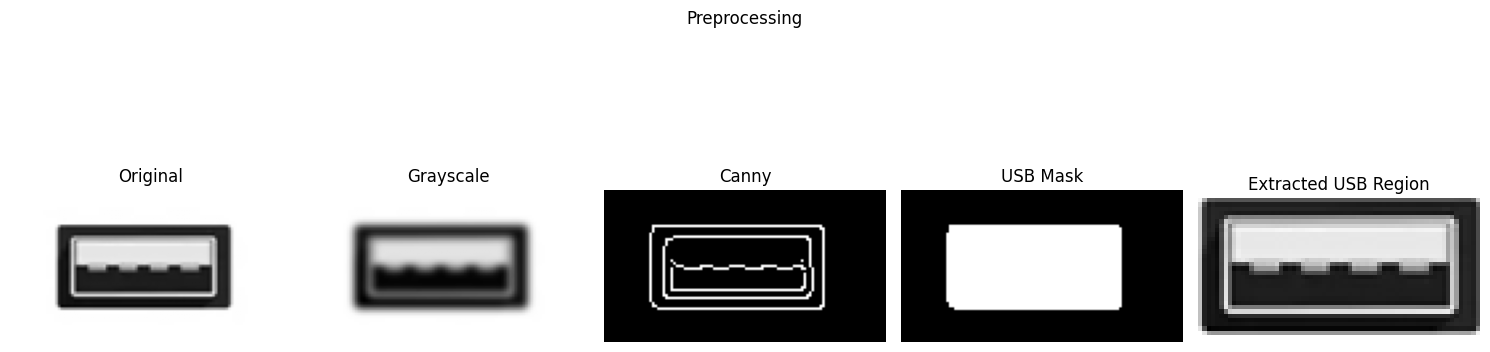

Extracted Features:
  - Aspect Ratio: 2.10
  - Area: 2007.5
  - Perimeter: 189.07
  - Compactness: 0.71
  - Corner Count: 351
  - Pin Count: 0
  - Horizontal Lines: 0
  - Rectangularity: 0.95
  - Symmetry Score: 0.00568182
  - Central Line Detected: True
  - Central Line Length: 64.00
  - End Roundedness: 1.00


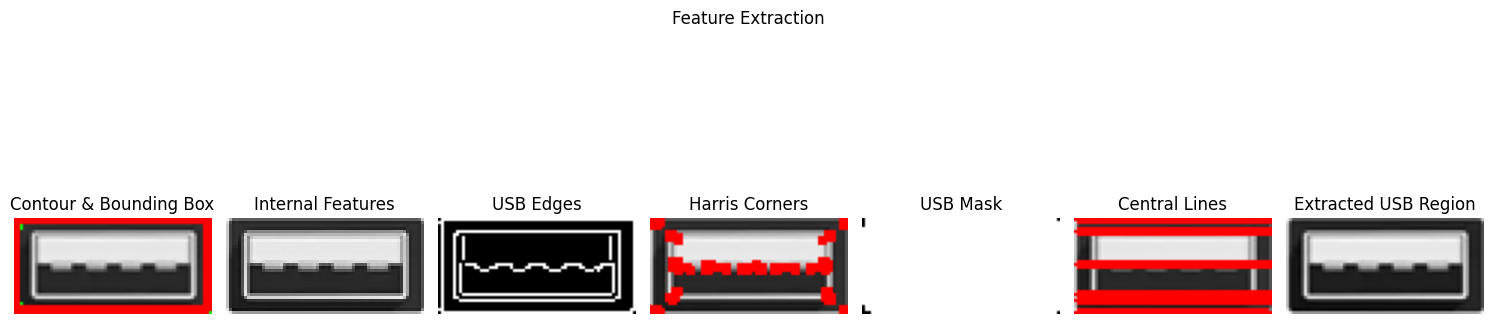

  Aspect Ratio: 2.10
  Compactness: 0.71
  Corner Count: 351
  Pin Count: 0
  Horizontal Lines: 0
  Rectangularity: 0.95
  Symmetry Score: 0.00568182
  Area: 2007.5
  Central Line Detected: True
  Central Line Length: 64.00
  End Roundedness: 1.00
USB-A: 0.19
  Reasons: Aspect ratio 2.10 fits USB-A range, Rectangularity 0.95 matches USB-A profile, Compactness 0.71 fits USB-A, Small size (area: 2007.5) less likely for USB-A
USB-B: 0.00
  Reasons: 
USB-C: 0.49
  Reasons: High symmetry (score: 0.0057), Strong central line (64.00 of width), Rounded ends detected (score: 1.00)
Micro-USB: -0.07
  Reasons: High rectangularity 0.95 common in Micro-USB, Compactness 0.71 typical of Micro-USB shape, Small size (area: 2007.5) typical of Micro-USB, High corner count 351 matches Micro-USB, Central line invalid for Micro-USB
Mini-USB: 0.41
  Reasons: Aspect ratio 2.10 outside Mini-USB ideal range, Compactness 0.71 fits Mini-USB profile, High corner count 351 matches Mini-USB, Small size (area: 2007.5

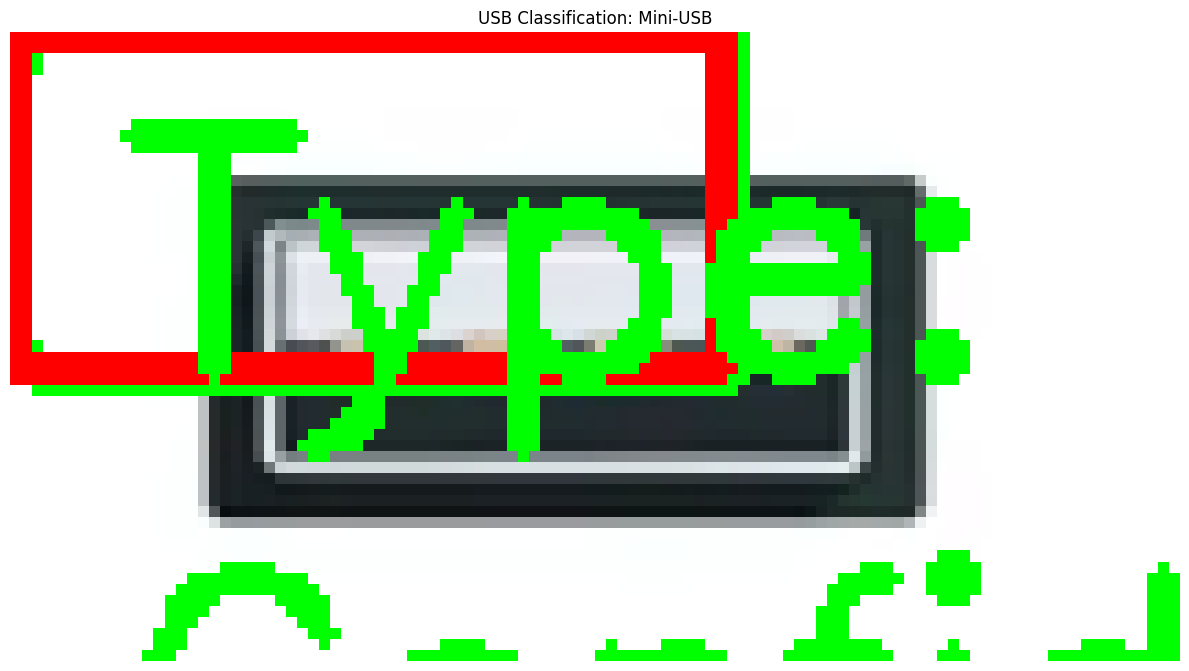

USB Type: Mini-USB
Confidence: 0.49
Reason: High symmetry (score: 0.0057), Strong central line (64.00 of width), Rounded ends detected (score: 1.00)


In [321]:

try:
    usb_type, confidence, reason, result_img = process_image(image)
    print(f"USB Type: {usb_type.value}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Reason: {reason}")

    cv.imwrite('result.jpg', result_img)

except Exception as e:
    print(f"Error processing image: {str(e)}")